# The Observation Operator for Stellar Population-Kinematic modelling

## Example Usage

In [ ]:
# get the operator
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(max_order_hermite=4)

# get a distribution funtion
from uq4pk_src.distribution_function import RandomGMM_DistributionFunction
df = RandomGMM_DistributionFunction(modgrid=G.ssps)

# define LOSVD parameters
V, sigma, h0, h1, h2, h3, h4 = 1., 0., 0., -0.05, 0.1
Theta_v = [V, sigma, h0, h1, h2, h3, h4]

# evaluate the operator
ybar = G.evaluate(df.F, Theta_v)

## Requirements

Before running this code you will need to install

- [astropy](https://docs.astropy.org/en/stable/install.html)

as well as a number of standard Python packages,

- numpy
- scipy
- matplotlib
- os 

## Installation

To import and run this code, you will need to put it somewhere accessible to your Python installation. If this is unfamiliar you you, I recommend the following simple solution. Set an environment variable ``PYTHONPATH`` to any convenient location, e.g. 

``setenv PYTHONPATH = '/Users/your_name/Library/MyPythonLibrary'``

then create this directory, and copy the entire directory ``uq4pk_src`` (i.e. the source code) to that location. The following import statement should then be successful,

In [2]:
import uq4pk_src

## Evaluating the Observation Operator

The first step is to initialise the observation operator object,

In [3]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(max_order_hermite=4)

Distribution functions should have shape (12, 53)


This initialises various properties of the SSP models and the LOSVD. One value we must provide is the maximum order of Hermite polynomial that we will use in the expansion: 4 is sufficient for now. We are also told the shape of the distributiuon function that which is consistent with the grid of SPP models.

To evaluate this, let's generate a (random, unrealsitic) input distributiuon function, namely a Gaussian mixture,

In [4]:
from uq4pk_src.distribution_function import RandomGMM_DistributionFunction
df = RandomGMM_DistributionFunction(modgrid=G.ssps)
print('Distribution function stored at df.F')
print(f'This has shape {df.F.shape}')

Distribution function stored at df.F
This has shape (12, 53)


Let's set parameters Theta_v of the LOSVD

In [5]:
V = 30.
sigma = 100.
h0, h1, h2, h3, h4 = 1., 0., 0., -0.05, 0.1
Theta_v = [V, sigma, h0, h1, h2, h3, h4]

And then to evaluate the operator,

In [6]:
ybar = G.evaluate(df.F, Theta_v)

To look at the generated result,

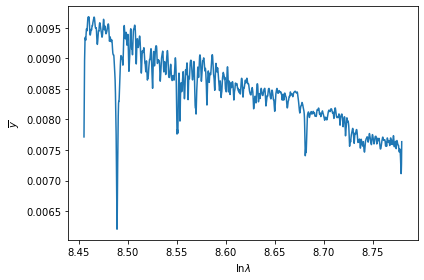

In [7]:
import matplotlib.pyplot as plt
plt.plot(G.ssps.w, ybar)
plt.gca().set_xlabel('$\ln \lambda$')
plt.gca().set_ylabel('$\overline{y}$')
plt.tight_layout()

## Error: wrong definition of the GH-LOSVD

I made an error in the definition of the GH-LOSVD. The normal density should be "un-whitened", i.e.

$$
L(v ; \theta_v) = \mathcal{N}(v ; V, \sigma^2) \left[\sum_{m=0}^{M} h_m H_m(\hat{v})\right]
$$

$$
\hat{v} = \frac{v - V}{\sigma}
$$

The incorrect "whitened" version differs by a factor of $1/\sigma$. All calculations in the code use the correct version.

## Evaluating the Convolution

Equation (1.3) of the document "Reformulation of the model using curvelets" is a convolutuion between the composite spectrum $S$ and the LOSVD $L$. We evaluate it using Fourier transforms. Here are some notes about how we evaluate this convolution.

### Logarithmic Resampling for Convolution

See equations (2-7) of [the STECKMAP paper](https://arxiv.org/pdf/astro-ph/0507002.pdf) to see the transformations applied in order to convert (1.3) into a standard convolution. One necessary transformation is $w = \ln \lambda$ i.e. going to the logarithm of wavelength. We therefore logarithmically re-sample the SSP model wavelengths. The resampled values are stored in

``G.ssps.w``

### Pre-calculation of the Fourier Transforms of the SSP models

The Fourier transforms of the SSP models are pre-calculated when we create the ``ObservationOperator`` object, i.e. line 30 of ``observation_operator.py``. These are stored in the attribute ``G.ssps.F_tilde_s``. To get the Fourier transform of the composite spectrum $S$, we must evaluate the integral of FT's of the template spectra over the distribtuion funtion - i.e. the Fourier transformed version of equation (1.2) of "Reformulation of the model using curvelets". We approcimate this integral by the sum evaluated on line 101 of ``observation_operator.py``.

### Analytic Fourier Transforms of GH-LOSVDs

We use analytic expressions to evaluate FTs of the GH-LOSVDs. These can be found in Sections 2.3 and 4.4 of [the PPXF paper](https://arxiv.org/pdf/1607.08538.pdf).